In [21]:
import json
import pickle
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from pycocotools import mask
import itertools
import scipy.io

In [136]:
def sort_by_mask_area(masks):
    return sorted(masks, reverse=True, key=lambda m: mask.area(m))

def overlapping_percentage(mask1, mask2):
    return mask.area(mask.merge([mask1, mask2], intersect=True))/min(mask.area([mask1, mask2]))
    
# only assess the top 'process_limit' number of largest masks.
def remove_overlapping_small_objects(masks, threshold=0.9, process_limit = 100):
    if len(masks) == 0:
        return []
    deleted_index = []
    sorted_masks = sort_by_mask_area(masks)

    for i, current_mask in enumerate(sorted_masks):
        if i in deleted_index:
            continue
        if i > process_limit:
            break
        for j in range(i+1, len(sorted_masks)):
            if j in deleted_index:
                continue
            test_mask = sorted_masks[j]
            overlapping = overlapping_percentage(current_mask, test_mask)
            if overlapping > threshold:
                deleted_index.append(j)
    return [m for i, m in enumerate(masks) if i not in deleted_index]

def remove_overlapping_cross_classes(multiclass_masks, threshold = 0.9, process_limit = 100):
    
    #assign attribute for classification
    for i, masks_of_one_class in enumerate(multiclass_masks):
        for mask in masks_of_one_class:
            mask['is'] = i
        
    # flatten all masks in one array
    combined_masks = []
    [combined_masks.extend(masks_of_one_class) for masks_of_one_class in multiclass_masks]
    processed_masks = remove_overlapping_small_objects(combined_masks, threshold)
    
    ret =  [];
    for i in range(len(multiclass_masks)):
        ret.append([mask for mask in processed_masks if mask['is'] == i])
    return ret

In [ ]:
# generate filtered mask;
counter = 0
with open('infer_result' ,'rb') as input_file, open('infer_result_remove_overlapping', 'wb') as output_file:
    try:
        while True:
            obj = pickle.load(input_file)
            m = json.loads(obj['m'])
            segms = m['cls_segms']
            if not segms:
                # just write it back as is
                pickle.dump(obj, output_file)
                continue
            c_alpha = len(segms[1])
            c_beta = len(segms[2])
            m['cls_segms'] = processed = remove_overlapping_cross_classes(segms)
            reduced_alpha = c_alpha - len(processed[1])
            reduced_beta =  c_beta - len(processed[2])
            if reduced_alpha or reduced_beta:
                print("Alpha count reduced {}, beta count reduced {}".format(reduced_alpha , reduced_beta))
            
            if counter % 100 == 0:
                print("processed {} objects".format(counter))
            obj['m'] = json.dumps(m)
            pickle.dump(obj, output_file)
            counter +=1
    except Exception as e:
        raise e

processed 0 objects
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 2, beta count reduced 0
processed 100 objects
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 0
processed 200 objects
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 0
Alpha count 

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta coun

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 3
processed 1300 objects
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha cou

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 3, beta count reduced 0
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 1, beta coun

Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 1, beta count reduced 4
Alpha count reduced 0, beta coun

Alpha count reduced 3, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
processed 2100 objects
Alpha count reduced 1, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha cou

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 4, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
processed 2600 objects
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 2, beta count reduced 5
Alpha cou

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 1, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta coun

Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
processed 3100 objects
Alpha count reduced 2, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 2, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha cou

Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 2, beta count reduced 1
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
processed 3800 objects
Alpha count reduced 2, beta count reduced 0
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 3
Alpha cou

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 2, beta count reduced 0
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 2, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 1, beta coun

Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
processed 4300 objects
Alpha cou

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
processed 5000 objects
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 0
Alpha cou

Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 2, beta count reduced 4
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 2, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta coun

Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
processed 6400 objects
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha cou

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 2, beta count reduced 0
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta coun

Alpha count reduced 1, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
processed 7100 objects
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 1, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 2
Alpha cou

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 2, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 5
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 1, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
processed 7800 objects
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 1
Alpha cou

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 3, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 1, beta count reduced 2
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 1, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 2, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 2, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 6
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 2, beta count reduced 0
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 1, beta count reduced 3
processed 8700 objects
Alpha count reduced 0, beta count reduced 1
Alpha cou

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
processed 8900 objects
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 2, beta count reduced 2
Alpha count reduced 2, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha cou

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 9
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 2, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 4
Alpha count reduced 2, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta coun

Alpha count reduced 1, beta count reduced 2
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
processed 9800 objects
Alpha count reduced 0, beta count reduced 1
Alpha cou

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 1, beta count reduced 1
processed 10000 objects
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 4
Alpha co

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 2, beta count reduced 0
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 2, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 2, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 6
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 3, beta count reduced 3
Alpha count reduced 0, beta coun

Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 1, beta count reduced 7
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
processed 11300 objects
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 7
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 7
Alpha count reduced 1, beta count reduced 2
Alpha co

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
processed 11500 objects
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha co

Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta coun

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 4
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 5
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 4
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 6
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 1, beta coun

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
processed 12800 objects
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 5
Alpha co

Alpha count reduced 1, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
processed 13000 objects
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha co

Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
processed 13200 objects
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 2, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 1, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha co

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta coun

Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 9
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 2, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 1, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 6
processed 15500 objects
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha co

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 8
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 8
Alpha count reduced 0, beta count reduced 2
processed 15900 objects
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha co

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 1, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 8
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta coun

C:\Users\wuyua\Anaconda3\envs\Aug\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in ulong_scalars
  """



Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 2, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta cou

Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 5
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 0
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 1, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 8
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta coun

Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta coun

Alpha count reduced 1, beta count reduced 2
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 8
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 8
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 8
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 8
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 8
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 8
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 1, beta count reduced 6
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 8
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 1, beta count reduced 6
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 1, beta count reduced 4
Alpha count reduced 1, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 8
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 9
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 9
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 9
Alpha count reduced 1, beta count reduced 6
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 1, beta count reduced 2
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta coun

Alpha count reduced 0, beta count reduced 3
processed 27300 objects
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha co

Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
processed 27500 objects
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 1, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 2
Alpha co

Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 10
Alpha count reduced 0, beta count reduced 8
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 6
processed 27700 objects
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha c

Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
processed 27900 objects
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 6
Alpha co

Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
processed 28100 objects
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha co

Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 9
Alpha count reduced 0, beta count reduced 7
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 9
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
processed 28300 objects
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 5
Alpha co

Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 6
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 4
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 5
Alpha count reduced 0, beta count reduced 3
Alpha count reduced 0, beta count reduced 1
Alpha count reduced 0, beta count reduced 2
processed 28500 objects
Alpha co

In [128]:
# count change:`
window_size = 2*60 # 1min

alpha_count = []
beta_count = []
time = []
with open('infer_result_remove_overlapping' ,'rb') as input_file:
    try:
        while True:
            alpha_num = 0
            beta_num = 0
            time_list = []
            for i in range(window_size):
                obj = pickle.load(input_file)
                try:
                    t = int(obj['f'].split('.')[0])
                except:
                    continue
                time_list.append(t)
                m = json.loads(obj['m'])['cls_segms']
                if not m:
                    continue
                m_alpha = len(m[1])
                m_beta = len(m[2])
                alpha_num += m_alpha
                beta_num += m_beta
            alpha_count.append(alpha_num)
            beta_count.append(beta_num)
            time.append(np.average(time_list))
    except Exception as e:
        raise e

EOFError: Ran out of input

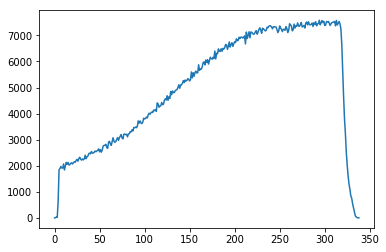

In [130]:
plt.plot(beta_count)

In [11]:
scipy.io.savemat("counts", {"alpha_count": np.array(alpha_count), "beta_count": np.array(beta_count), "time": np.array(time)})

In [133]:
# generate area data
window_size = 2*60 # 1min

alpha_dist = []
beta_dist = []
time = []
with open('infer_result_remove_overlapping' ,'rb') as input_file:
    try:
        while True:
            alpha_list = []
            beta_list = []
            time_list = []
            for i in range(window_size):
                obj = pickle.load(input_file)
                try:
                    t = int(obj['f'].split('.')[0])
                except:
                    continue
                    
                clssegms = json.loads(obj['m'])['cls_segms']
                if clssegms:
                    alpha_list.extend(mask.area(json.loads(obj['m'])['cls_segms'][1]).tolist())
                    beta_list.extend(mask.area(json.loads(obj['m'])['cls_segms'][2]).tolist())
                    time_list.append(t)
            alpha_dist.append(alpha_list)
            beta_dist.append(beta_list)
            time.append(np.average(time_list))
    except Exception as e:
        raise (e)

EOFError: Ran out of input

In [134]:
scipy.io.savemat("areas", {"alpha_dist": alpha_dist, "beta_dist": beta_dist, "time": time})

In [135]:
len(alpha_dist)

339

In [18]:
# generate ellipse data
window_size = 2*60 # 1min

alpha_ellipse = []
beta_ellipse = []
time = []
with open('ellipse.p' ,'rb') as input_file:
    try:
        while True:
            alpha_list = []
            beta_list = []
            time_list = []
            for i in range(window_size):
                obj = pickle.load(input_file)
                t = obj['timestamp']
                time_list.append(t)
                alpha_list.extend(obj['alpha_ellipses'])
                beta_list.extend(obj['beta_ellipses'])
            alpha_ellipse.append(alpha_list)
            beta_ellipse.append(beta_list)
            time.append(np.average(time_list))
    except Exception as e:
        print(e)

Ran out of input


In [19]:
scipy.io.savemat("ellipses", {"alpha_ellipse": alpha_ellipse, "beta_ellipse": beta_ellipse, "time": time})